In [1]:
%matplotlib inline

Z = number of blades

$ \Gamma $ = bound circulation

G = dimensionless bound circulation

$ x, r, \theta $ = cylindrical coordinates 

V = wind speed, undisturbed flow, m/s

$ u_{a}, u_{t} $ = induced axial and tangental velocity, respectively 

$ \mathrm{d}u_{t1}(r) = - \frac{\mathrm{d}\Gamma}{4\pi}  \sum_{j=0}^{Z-1}   \int_0^\infty \frac{\tan \beta' (r-r'\cos\theta_j - r' \theta' \sin\theta_j ) r' \mathrm{d}\theta'}  {S^3_j}  - \frac{Z \mathrm{d}\Gamma} {4\pi r}  $


$ \mathrm{d}u_{a1}( r ) = - \frac{\mathrm{d}\Gamma}{4\pi}  \sum_{j=0}^{Z-1}   \int_{0}^{\infty} \frac{( r'-r \cos\theta_{j}) r' \mathrm{d}\theta'} {S^3_j }   $

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
from scipy.integrate import quad
from scipy import interpolate

In [3]:
V = 10.
n = 3.25 # s^-1
z = 2.
D = 7.

KT1= 0.
rho= 1.2
ni= 15e-6
R = D/2.
r1 = 1000000.
e1= 0.001
J= V/(n*D)
P=13500 # Watts, close to the Betz limit for D = 7m, V = 10 m/s
cp = 8.*P/(np.pi*rho*D**2*V**3)
tmp = np.sqrt(4.*cp/3.)
ct = -2.* tmp * np.sinh(np.arcsinh((-2.*cp**2)/tmp**3)/3.)
KT = np.pi*ct*J**2/8.
print(f"Cp = {cp}, Ct = {ct}, KT = {KT}.")

Cp = 0.5846508113579829, Ct = 0.5233548133756303, KT = 0.039709398307492746.


In [13]:
drh = 0.2 # dimensionless hub radius
rh= drh*R # hub radius, m
dh= rh * 2.  # hub diameter, m

omega = 2. * np.pi * n

# Chord distribution along the blade in 4 steps (DNV GL BLADED has 10)
chh= 0.07 #!14
ch1= 0.09 #!16
ch2= 0.09 #	!16
cht= 0.07 #	!14
chr1= 0.4
chr2= 0.7

deltah= 0.13
deltat= 0.04

B1=0.0733
B2=0.0174
# These are specific to the NACA 66 mod a=0.8

xs= 0.
ts= 0.

# case where Circulation distribution gradient (dG/dx) is zero both at hub and tip of the blade
#alfa= 0.5
#beta= 0.5
# case where Circulation distribution gradient (dG/dx) is zero both at hub and tip of the blade
alfa= -0.5
beta= 0.5

lt= V/(omega*R)
li= 0.944*lt-0.065 #!???
#li = .26*lt**2 + .812*lt + .35*KT + .03

xnaca = np.array([0., .0125, .025, .05, .075, .1, .2, .3, .4, .45, .5, .6, .7, .8, .9, .95, 1.])
fcnacaa08b005 = np.array([0., .0686, .142, .282, .389, .475, .725, .881, .97, .992, 1., .971, .877, .69, .352, .168, 0.])
ftnaca66 = np.array([0., .231, .306, .419, .508, .584, .8, .927, .99, 1., .992, .931, .807, .622, .375, .229, .006])
#integer(4), parameter:: maxft= 10

#np= 40
M= 7
No= M+1

#real(8) function chord(r)
def chord(r):
    #real(8) chh, ch1, ch2, cht, drh, chr1, chr2
    #common /cho/ chh, ch1, ch2, cht, drh, chr1, chr2
    if (r > chr2):
        return (r-chr2)*((cht-ch2)/(1.-chr2)) + ch2
    elif (r > chr1):
        return (r-chr1)*((ch2-ch1)/(chr2-chr1)) + ch1
    else:
        return (r-drh)*((ch1-chh)/(chr1-drh)) + chh
#end function

def ktpif(dr):
        return interpolate.splev(dr, CSCOEF, der=0)
#real(8) function ktpif(dr)
#real(8) dr, break(8), cscoef(4,8)
#common /sp1/ break, cscoef
#    ktpif= dCSVAL(dr, 7, BREAK, CSCOEF)
#end function

# x distance to dr
#real(8) function x2dr(x, drh)
#real(8) x, drh
def x2dr(x, drh):
    return (x*(1.-drh)+1.+drh)/2.
#end function

print(omega)

20.420352248333657


0
1
2
3
4
5
6
7
[[ 0.9829731   0.85021714  0.60263464  0.27366299 -0.09226836 -0.44573836
  -0.73900892 -0.93247223]
 [ 0.99318924  0.94008685  0.84105385  0.7094652   0.56309266  0.42170466
   0.30439643  0.22701111]
 [ 3.47616234  3.29030399  2.94368849  2.48312819  1.9708243   1.4759663
   1.06538752  0.79453888]] 

[[ 0.93247223  0.73900892  0.44573836  0.09226836 -0.27366299 -0.60263464
  -0.85021714 -0.9829731 ]
 [ 0.97298889  0.89560357  0.77829534  0.63690734  0.4905348   0.35894615
   0.25991315  0.20681076]
 [ 3.40546112  3.13461248  2.7240337   2.2291757   1.71687181  1.25631151
   0.90969601  0.72383766]]
[ 0.04120616  0.04488328  0.05121415  0.0605227   0.07327507  0.08992163
  0.10986147  0.12711434] 
 [ 0.07180074  0.07695976  0.08478031  0.09        0.09        0.08589461
  0.07599131  0.07068108]


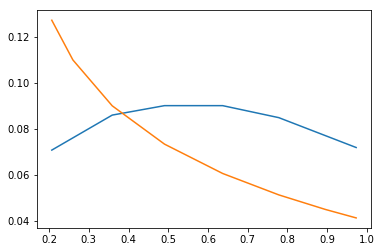

In [5]:
xkk = np.zeros((3, No)) #, order='F'
xii = np.zeros((3, No))

delta = np.zeros(No) #Chord distribution along the blade
c = np.zeros(No)

for k in range(0, No):
    print(k)
    xkk[0, k]= np.cos(np.pi*(2.*(k+1)-1.)/(2.*No+1.))
    xkk[1, k]= x2dr(xkk[0, k], drh)
    xkk[2, k]= R*xkk[1, k]
    #!print*, xkk(0,k), xkk(1,k), xkk(2,k)

print(xkk, "\n")

for i in range(0, No):
    xii[0, i]= np.cos(2*np.pi*(i+1)/(2*No+1.))
    xii[1, i]= x2dr(xii[0, i], drh)
    xii[2, i]= R*xii[1, i]

print(xii)

for i in range(0, No):
    delta[i]= (1.-np.log10(9.*(xii[1, i]-drh)/(1.-drh)+1.))* (deltah-deltat)+deltat
    c[i]= chord(xii[ 1, i])

print(delta, "\n", c)

plt.plot(xii[1,:], c)
plt.plot(xii[1,:], delta)
plt.show()


In [6]:
def itp(z, tbp, r, rh, r1, rp):
    
#real(8) function itp(z, tbp, r, rh, r1, rp)
#real(8) z, r, r1, rh, rp, tbp
#real(8) mu, mup, muh, mu1, u, up, uh, u1
#real(8) s, rer, ni, a, b, y, y1, yh, yp
#real(8) f1, f2, f12, dit, it, rrr

    if (r != rp):
        rrr= rp*tbp
        mu = r / rrr
        mup = rp / rrr
        muh = rh / rrr
        mu1 = r1 / rrr
        
        u = np.sqrt(1. + mu**2)
        up = np.sqrt(1. + mup**2)
        uh = np.sqrt(1. + muh**2)
        u1 = np.sqrt(1. + mu1**2)

        s = np.sign(r - rp)
        
        rer = 1. - rp / r
        ni = ((((u - 1.) / mu) * (mup / (up - 1.)))**(z * s)) * np.exp(z * abs(u - up))
        f1 = (s / (2. * z * mup)) * np.sqrt(up / u)
        f2 = 1. / (ni - 1.) - (s / (24. * z)) * ((9. * mup**2 + 2.) / up**3 + (3. * mu**2 - 2.) / u**3) * np.log(1. + (1. / (ni - 1.)))
        
        if (r > rp):
            return z * rer * (1. + 2 * mup * z * f1 * f2)
        else:
            return 2 * (z**2) * rer * mup * f1 * f2
    else:
        return np.sin(np.arctan(tbp))


#!    y = yfun(u)
#!    yp = yfun(up)
#!	if (rh < 1d-3) then
#!		b= 0.
#!	else
#!		yh = yfun(uh)
#!	    b = 1. / (1. - dEXP(-z * (y + yp - 2 * yh)))
#!	end if
#!   if (r1 > 1000.) then
#!		a= 0.
#!	else
#!		y1 = yfun(u1)
#!		a = 1. / (1. - dEXP(-z * (2 * y1 - y - yp)))
#!	end if
#!    dit = -z * rer * dsqrt(up / u) * (a - b)
# itp = it !+ dit


def iap(z, tbp, r, rh, r1, rp):
    mu = r / (rp*tbp)
#real(8) function iap(z, tbp, r, rh, r1, rp)
#real(8) z, r, r1, rh, rp, tbp
#real(8) mu, it, itp

    return mu * (itp(z, tbp, r, rh, r1, rp) + z * (rp / r - 1.))



# no sign function in Fortran..
#real(8) function sgn(x)
#    IF (x < 0.) THEN
#		sgn= -1.
#	ELSE IF (x == 0.) THEN
#		sgn= 0.
#	ELSE
#		sgn= 1.
#    END IF
#end function

#
#real(8) FUNCTION yfun (u)
#real(8) u
#   yfun = u - .5 * LOG((u + 1.) / (u - 1.))
#END FUNCTION

def Gfx(x): 
    #real(8) function Gfx(x, m, a, b, coefs)
    #integer(4) m, i
    #real(8), external:: jp
    #real(8) sum, h, x, a, b, coefs(0:m)
    sum= 0.
    for i in range( 1, M+1):
        sum= sum + a[i] * special.eval_jacobi(i-1, alfa+1., beta+1., x) / float(i)
    h= -a[0]*(.5*(beta-alfa+1.) * np.arccos(x)+(beta-alfa) * np.sqrt(1.-x**2.) + .5*(beta-alfa-1.) * x * np.sqrt(1-x**2.))
    # page 144 of [1]
    return h - .5*((1.-x)**(alfa+1.))*((1.+x)**(beta+1.))*sum


def Gdx(x):
    #integer(4) m, i
    #real(8), external:: jp
    #real(8) sum, x, a, b, coefs(0:m)
    sum= 0.
    for i in range(0, M+1):
        sum= sum + a[i] * special.eval_jacobi(i, alfa, beta, x)
    
    return ((1.-x)**(alfa))*((1.+x)**(beta)) * sum
#end function


In [14]:
a = np.zeros( No )
s = np.zeros( (No, No) )
RHS = np.zeros(No)

phi = np.zeros(No)

#cl cd deltac 
#allocate(s(1:M+1,0:M), a(0:M), RHS(1:M+1))
#allocate( xii(0:2,1:No), xkk(0:2,1:No))
#allocate( cl(1:No), cd(1:No), c(1:No))
#allocate( deltac(1:No), delta(1:No), phi(1:No))

#real(8)	xdata(8), fdata(8)
xdata = np.zeros(No)
fdata = np.zeros(No)
cl = np.zeros(No)
cd = np.zeros(No)
deltac = np.zeros(No)

KT = np.pi*ct*J**2/8.
KT1 = 0.

CSCOEF = np.zeros(No)
#real(8)	break(8), cscoef(4,8)

# main loop for the Integro-differential equation

while (abs(KT - KT1) > e1):
    for i in range(0, No):
        for nn in range( 0, No):
            sum= 0.
            for k in range(0, No): 
                c2tk2= np.cos(np.pi*(2.*k-1.)/(2.*(2.*No+1.)))**2
                tif= itp(z, li/xkk[1,k], xii[1,i], 1e-4, 1., xkk[1,k])
                sum= sum + c2tk2*special.eval_jacobi(nn, -.5, .5, xkk[0,k])*tif/(xkk[0,k]-xii[0,i])
                # from SciPy -- special.eval_jacobi(nn, alpha, beta, x)
                #end do
            s[i,nn]= (1/(1.-drh))*(4.*np.pi/(2.*No+1.))*sum
            #end do
        s[i,0]= s[i,0] + np.pi*z/(2.*xii[1,i])
        # RHS(i)= 2.*((lt-li)/lt)*(xii(1,i)*li/(xii(1,i)**2+li**2))
        be = np.arctan(lt/xii[1,i])
        bei= np.arctan(li/xii[1,i])
        RHS[i]= np.sin(be-bei) * np.sin(bei) / np.sin(be)
        #end do
    
    #print(s, "\n",RHS)
    #call dlsarg(M+1, s, M+1, RHS, 1, a)
    #Solves a real general system of linear equations with iterative refinement (IMSL again).
    # s*a=RHS ... solve(s,RHS)
    a = np.linalg.solve(s, RHS)
    
    for i in range( 0, No):
        be = np.arctan(lt/xii[1,i])
        bei= np.arctan(li/xii[1,i])
        u1= np.sin(be-bei) * np.sin(bei) / np.sin(be)
        v1= 1 - np.tan(bei)*(np.pi*xii[1,i] / J + u1)
        xdata[No-i-1]= xii[1,i]
        tempg= Gfx(xii[0,i])
        tempvrm= np.pi*xii[1,i]/J + ((lt-li)/lt)*(xii[1,i]*li/(xii[1,i]**2+li**2))
        tempvrm= np.pi*xii[1,i]/J + np.sin(be-bei) * np.sin(bei) / np.sin(be)
        cbi= np.cos(bei)
        vri= np.sqrt((1-v1)**2 + (np.pi*xii[1,i]/J)**2)
        rns= vri * c[i] * R / ni # WTF защо Рейнолдс всеки път?
        
        cd[i]= .05808*(1. + 2.3*delta[i])/rns**(.1458) 
        # for NACA 66 a=0.8 (mod b=0.05) airfoils only
        
        cl[i]= 2.*np.pi*tempg/(c[i]*vri)
        fdata[No-i-1]= tempg*vri*cbi*(1.-(cd[i]/cl[i]) * li / xii[1,i])
        #end do
    
    #CALL dCSINT (No, XDATA, FDATA, BREAK, CSCOEF)
    #This IMSL function computes the cubic spline interpolant with the ‘not-a-knot' condition.
    #f2 = interp1d(xdata, fdata, kind='cubic')
#>>> x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
#>>> y = np.sin(x)
    CSCOEF = interpolate.splrep(xdata, fdata, s=0)
#>>> xnew = np.arange(0, 2*np.pi, np.pi/50)
#>>> ynew = interpolate.splev(xnew, tck, der=0)
    
    
    #CALL dQDAGS (ktpif, drh, 1., 0., 0.0001, RES1, ERR1)
    # from scipy.integrate import quad
    RES1 = quad(ktpif, drh, 1.)
    
    print(RES1)
    #print("ERR= ", RES1[1])
    
    KT1 = -z * J**2. * np.pi * RES1[0] / 2.

    print( KT1, li)
    print(f"KT = {KT}, KT1 ={KT1}, ERR ={KT-KT1}")
          
    li= li * KT / KT1
#end do

#CALL dWRRRN ('a', 1, M+1, a, 1, 0)
# from IMSL again - now it's simply print...
print(f"a = { a}, lambda_t ={lt}, lambda_i ={li}")

for i in range(0, No):
    deltac[i]= B1 * cl[i]
    phi[i]= np.arctan(li / xii[1,i]) - B2*cl[i]
    # good candidate for future rework -- need to read real airfoilds from data files


(-0.10502504304713389, 5.521582506358166e-09)
0.06374996327589955 0.06708111321208718
KT = 0.039709398307492746, KT1 =0.06374996327589955, ERR =-0.0240405649684068
(-0.09356937188561648, 7.313009702762531e-09)
0.05679639682489825 0.0417843478893
KT = 0.039709398307492746, KT1 =0.05679639682489825, ERR =-0.017086998517405506
(-0.07587309351810059, 6.675476474568871e-09)
0.04605479593316675 0.0292136721009
KT = 0.039709398307492746, KT1 =0.04605479593316675, ERR =-0.006345397625674001
(-0.06838313913365235, 1.4382178366341928e-08)
0.041508410584555656 0.0251886327574
KT = 0.039709398307492746, KT1 =0.041508410584555656, ERR =-0.00179901227706291
(-0.06619428864855405, 1.3446083950912641e-08)
0.04017978329726354 0.0240969344983
KT = 0.039709398307492746, KT1 =0.04017978329726354, ERR =-0.0004703849897707904
a = [ 0.00627015  0.01172732  0.012877    0.01220297  0.00968145  0.00693316
  0.00425394  0.00199762], lambda_t =0.1399164334873805, lambda_i =0.02381483152619687


[ 0.02792839  0.0309434   0.03517593  0.04265413  0.05535528  0.07602921
  0.10657089  0.1351069 ]


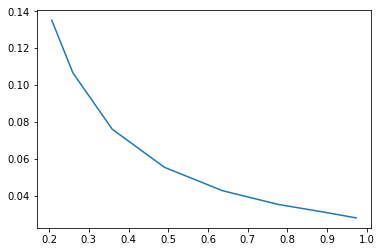

In [19]:
print(phi)
plt.figure()
plt.plot(xii[1,:], phi)
plt.show()

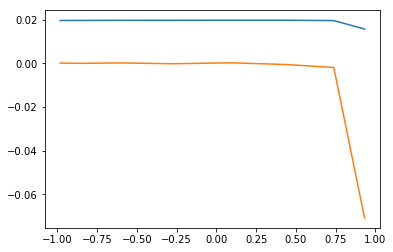

In [26]:
#x = np.linspace(drh, 1, 1000)
x = np.zeros(8)
x = xii[0,:]
yg = Gfx(x)
ygp = Gdx(x)
plt.figure()
plt.plot(x, -yg)
plt.plot(x, -ygp)
plt.show()

## Future work

Output to PFF (Propeller Free Format), see CAESES forum:
https://www.caeses.com/blog/2017/introduction-to-pff-propeller-free-format/

DNV GL Wind turbine software package BLADED

NREL

https://en.wikipedia.org/wiki/Lifting-line_theory

https://en.wikipedia.org/wiki/Wind-turbine_aerodynamics

https://en.wikipedia.org/wiki/Tip-speed_ratio

Special for Jacobi polynomials:
https://docs.scipy.org/doc/scipy-0.14.0/reference/special.html

eval_jacobi(n, alpha, beta, x[, out])
Evaluate Jacobi polynomial at a point.

jacobi(n, alpha, beta[, monic])
Returns the nth order Jacobi polynomial, P^(alpha,beta)_n(x) orthogonal over [-1,1] with weighting function (1-x)**alpha (1+x)**beta with alpha,beta > -1.



## References

1. Mishkevich V. G., A New Approach to Lifting Line Theory: Hub and Duct Effects,  Journal of Ship Research, Vol. 50, No. 2, June 2006, pp. 138-146 

2.	Rand O., Rosen A.  Efficient Method for Calculating the Axial Velocities Induced Along Rotating Blades by Trailing Helical Vortices. Journal of Aircraft, Vol. 21, June 1984

3.	Chiu Y. D., Peters D. A. Numerical Solutions of Induced Velocities by Semi-Infinite Tip Vortex Lines, Journal of Aircraft, Vol. 25, Aug. 1988

4. Dantchev O. D., Design of HAWT Blades using Lifting Line Theory, M.Sc. Thesis, TU - Sofia, 1996








